# Orography Tests

_Author:_ P. Gierz

The following documents some tests done to see if the `adjust_jan_spec` procedure works as expected

| `EXP_ID` | Job Number | `jan_spec` script  | Parent `EXP_ID` | Parent `echam` version | `unit.23` source | `unit.24` source |  Notes                    | Success |
|---------:|:-----------|:------------------:|:----------------|:----------------------:|:-----------------|:-----------------|---------------------------|:-------:|
| `orog_001` | 9713599 | A                   | `EXP003`        | `echam5`               | synthetic PI     | default          | PI Conditions, cold start | <font color='green'>✓</font> |
| `orog_002` | 9715407 | A                   | `lgmctl_wiso`         | `echam5`               | synthetic LGM    | LGM from X. Zhang| LGM Conditons, cold start |   <font color='red'>✗</font> |
| `orog_003` | 9717060 | A                   | `lgmctl_wiso`         | `echam5`               | synthetic LGM    | LGM from X. Zhang| LGM Conditions, warm start ocean|<font color='red'>✗</font>|
| `orog_004` | 9717340 | B                   | `E280`          | `echam6`               | synthetic PI     | default          | PI Conditions | <font color='green'>✓</font> |
| `orog_005` | 9717235 | None                |  None           | None                   | default          | default          | Complete atmosphere cold start, uses default `jan spec` | <font color='green'>✓</font> |
| `orog_006` | 9726644 | C                   | `Lev21ka`    | `echam6`               | synthetic LGM    | LGM from X. Zhang| LGM Conditions | <font color='red'>✗</font> |
| `orog_007` | 9727660 | C                   | `E280`          | `echam6`               | synthetic PI     | default          | PI Conditions, but generate `unit.23` from existing run| <font color='green'>✓</font>|
| `orog_008` | ??????? | D                   | `E280`          | `echam6`               | synthetic PI     | default          |                            | ? |
| `orog_009` | ??????? | D                   | `Lev21ka`    | `echam6`               | synthetic LGM    | LGM from X. Zhang| | ? |
| `orog_010` | 9729752 | C                   | `Lev21ka`    | `echam6`               | synthetic LGM    | default          | use `unit.23` from **LGM**, but `unit.24` from **PI**| <font color='red'>✗</font> | 

| `jan_spec` script | description | script name |
|:-----------------:|:------------|:------------|
| A                 | Interpolates both laterally and vertically | `adjust_jan_spec_from_T31.sh` |
| B                 | Transforms sp2gp, replaces variables, and back gp2sp | `adjust_jan_spec_from_T63.sh` |
| C                 | Only split levels for temperature into temperature and log surface pressure | `adjust_jan_spec_from_T63_without_gridpoint_smoothing.sh`|
| D                 | Generate relevant `unit.23` files from `restart_${PARENT_EXP_ID}_echam6_echam_????1231.nc` | Not available | 

Scripts can be retrieved here: https://github.com/pgierz/adjust_jan_spec

Results from `orog_001`, `orog_004`, and `orog_005` demonstrate that PI conditions seem to work normally. The initial `T63L47_jan_spec.nc` file, taken from the `POOL` directory, allows for a cold start (`orog_005`), and utilizing an `echam6` (`orog_004`) as well as a `echam5` (`orog_001`) file to regenerate the `T63L47_jan_spec.nc` (henceforth `unit.23`) 

It appears as if all of the `LGM` tests end in a failure resulting a lookup table overflow. Example taken from `orog_006`:

> `FATAL ERROR in cuadjtq (2):  lookup table overflow`

even if no interpolation is performed. The traceback shows that this appears to come from:

> ```868: Image              PC                Routine            Line        Source            
868: echam6             000000000166181D  tracebackqq_          Unknown  Unknown
868: echam6             00000000006E97F7  mo_exception_mp_f     Unknown  Unknown
868: echam6             00000000006C9AB7  mo_echam_convect_     Unknown  Unknown
868: echam6             000000000066856F  mo_cuadjust_mp_cu     Unknown  Unknown
868: echam6             0000000000681B2D  mo_cuinitialize_m     Unknown  Unknown
868: echam6             000000000068441B  mo_cumastr_mp_cum     Unknown  Unknown
868: echam6             000000000068336A  mo_cumastr_mp_cuc     Unknown  Unknown
868: echam6             0000000000CB44C5  physc_                Unknown  Unknown
868: echam6             0000000000D12441  scan1_                Unknown  Unknown
868: echam6             0000000000D2BAFD  stepon_               Unknown  Unknown
868: echam6             00000000004A425D  control_              Unknown  Unknown
868: echam6             00000000004CDEAC  MAIN__                Unknown  Unknown```

While I'm not sure about this, `cuadjtq` _could_ be something like "Adjust Temperature and Humidity", and since this is called from something called `mo_echam_convect`, it might be that this is causing some sort of instability in the `echam6` advenction scheme. 

I need to now look in more detail at what exactly is different about these files...

In [120]:
%%bash
mkdir -p data_from_mistral
remote_copy="rsync -avzhP"
remote_dir=/pf/a/a270077/PalMod_Update_Orography/
$remote_copy a270077@mistral.dkrz.de:${remote_dir}/T63L47_jan_spec.nc data_from_mistral
$remote_copy a270077@mistral.dkrz.de:${remote_dir}/T63L47_jan_spec_from_E280_T63L47_without_gp2sp.nc data_from_mistral
$remote_copy a270077@mistral.dkrz.de:${remote_dir}/T63L47_jan_spec_from_Lev21ka_T63L47_without_gp2sp.nc data_from_mistral
$remote_copy a270077@mistral.dkrz.de:${remote_dir}/E280_echam6_echam_2700_t.nc data_from_mistral

receiving file list ... 
1 file to consider
T63L47_jan_spec.nc
      11.66M 100%  107.97MB/s    0:00:00 (xfer#1, to-check=0/1)

sent 20.57K bytes  received 138 bytes  8.28K bytes/sec
total size is 11.66M  speedup is 563.02
receiving file list ... 
1 file to consider
T63L47_jan_spec_from_E280_T63L47_without_gp2sp.nc
      11.66M 100%  102.02MB/s    0:00:00 (xfer#1, to-check=0/1)

sent 20.57K bytes  received 169 bytes  13.83K bytes/sec
total size is 11.66M  speedup is 562.16
receiving file list ... 
1 file to consider
T63L47_jan_spec_from_Lev21ka_T63L47_without_gp2sp.nc
      11.66M 100%  112.33MB/s    0:00:00 (xfer#1, to-check=0/1)

sent 20.57K bytes  received 172 bytes  41.49K bytes/sec
total size is 11.66M  speedup is 562.08
receiving file list ... 
1 file to consider

sent 20 bytes  received 105 bytes  83.33 bytes/sec
total size is 9.39M  speedup is 75110.91


/pf/a/a270077/.bash_modules: line 2: module: command not found
/pf/a/a270077/.bash_modules: line 3: module: command not found
/pf/a/a270077/.bashrc: line 14: module: command not found
/pf/a/a270077/.bash_modules: line 2: module: command not found
/pf/a/a270077/.bash_modules: line 3: module: command not found
/pf/a/a270077/.bashrc: line 14: module: command not found
/pf/a/a270077/.bash_modules: line 2: module: command not found
/pf/a/a270077/.bash_modules: line 3: module: command not found
/pf/a/a270077/.bashrc: line 14: module: command not found
/pf/a/a270077/.bash_modules: line 2: module: command not found
/pf/a/a270077/.bash_modules: line 3: module: command not found
/pf/a/a270077/.bashrc: line 14: module: command not found


## Check the differences between the "Standard" `unit.23`, and the one made by the script

Since the `unit.23` file contains information on the spectral grid, examining differences visually is not trivial, as the `sp2gp` transformation modifies the values (demonstration below). This modification renders it impossible to associate differences to either to the synthetic `jan_spec.nc` generation or to `sp2gp` transformation. While the differences are small, the expected difference between the standard `unit.23` input file and a synthetically created one from `PI` conditions would hopefully also be small. Therefore, it is critical to be able to distringuish the difference source. 

In [119]:
%%bash
CDO=/usr/local/bin/cdo
$CDO -output -sub \
-gp2sp -sp2gp \
-selvar,t -seltimestep,1 data_from_mistral/E280_echam6_echam_2700_t.nc \
-selvar,t -seltimestep,1 data_from_mistral/E280_echam6_echam_2700_t.nc

  3.12639e-13            0  1.42109e-14            0 -1.04361e-13            0
 -1.15463e-14            0 -6.03961e-14            0 -2.30926e-14            0
 -2.39808e-13            0  1.39888e-14            0  2.43361e-13            0
  1.73195e-14            0  3.06422e-13            0 -1.11022e-15            0
 -4.02567e-13            0  7.99361e-15            0  4.20386e-13            0
 -1.38778e-15            0  -1.5965e-13            0  4.60743e-15            0
  2.40363e-14            0 -1.89293e-14            0 -1.71307e-13            0
  1.70974e-14  1.15035e-06  4.37095e-13  1.05415e-06  1.18239e-14  9.69672e-07
 -2.10498e-13  8.95079e-07 -1.49325e-14  8.28876e-07 -8.85403e-14  7.69844e-07
 -1.04361e-14  7.16978e-07  2.46969e-13  6.69442e-07  2.31482e-14  6.26539e-07
 -2.16493e-15  5.87683e-07 -5.66214e-15  5.52377e-07   1.5099e-14  5.20199e-07
  8.88178e-16  4.90787e-07  1.22236e-13  4.63833e-07  2.42029e-14  4.39067e-07
  1.64757e-13  4.16258e-07  1.39888e-14  3.95203e-07

cdo output: Started child process "sub -gp2sp -sp2gp -selvar,t -seltimestep,1 data_from_mistral/E280_echam6_echam_2700_t.nc -selvar,t -seltimestep,1 data_from_mistral/E280_echam6_echam_2700_t.nc (pipe1.1)".
cdo(2) sub: Started child process "gp2sp -sp2gp -selvar,t -seltimestep,1 data_from_mistral/E280_echam6_echam_2700_t.nc (pipe2.1)".
cdo(2) sub: Started child process "selvar,t -seltimestep,1 data_from_mistral/E280_echam6_echam_2700_t.nc (pipe2.2)".
cdo(3) gp2sp: Started child process "sp2gp -selvar,t -seltimestep,1 data_from_mistral/E280_echam6_echam_2700_t.nc (pipe3.1)".
cdo(4) selname: Started child process "seltimestep,1 data_from_mistral/E280_echam6_echam_2700_t.nc (pipe4.1)".
cdo(5) sp2gp: Started child process "selvar,t -seltimestep,1 data_from_mistral/E280_echam6_echam_2700_t.nc (pipe5.1)".
cdo(7) selname: Started child process "seltimestep,1 data_from_mistral/E280_echam6_echam_2700_t.nc (pipe7.1)".
cdo(6) seltimestep: Processed 195520 values from 1 variable over 2 timesteps (

Therefore, we examine differences directly on the spectral grid, and simply plot the differences of every point in the array on a histogram.

In [111]:
# Import plotting modules
import matplotlib.pyplot as plt
from scipy.io import netcdf
import seaborn as sns
import numpy as np
%matplotlib notebook
sns.set(style="darkgrid", palette="muted", color_codes=True)

In [112]:
# Define a plot function to quickly make histograms of differences
def plot_histograms_of_spectral_variables_between_two_files(f1, f2):
    f, axs = plt.subplots(1, 4, figsize=(9, 3), sharey=True)
    for v, ax, c in zip(["SVO", "SD", "STP", "Q"], axs.flatten(), ["b", "r", "g", "m"]):
        diff = f2.variables[v].data.flatten() - f1.variables[v].data.flatten()
        print(v, np.abs(diff).max())
        sns.distplot(diff, hist=True, kde=False, ax=ax, color=c)
        ax.set_title(v)
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    axs[0].set_ylabel("Number of Array Elements")
    plt.tight_layout()

<IPython.core.display.Javascript object>


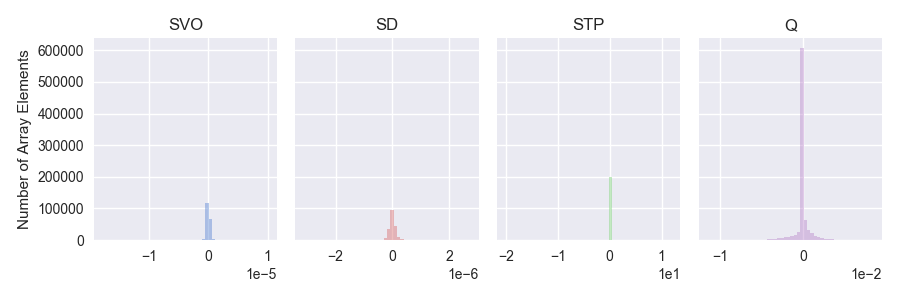

SVO 1.79942727141e-05
SD 3.12059041328e-06
STP 20.1015914981
Q 0.0115873308611


In [113]:
# Plot frequency distributions of differences for initial variables Standard vs. *PI*
f1 = netcdf.netcdf_file("data_from_mistral/T63L47_jan_spec.nc")
f2 = netcdf.netcdf_file("data_from_mistral/T63L47_jan_spec_from_E280_T63L47_without_gp2sp.nc")

plot_histograms_of_spectral_variables_between_two_files(f1, f2)

<IPython.core.display.Javascript object>


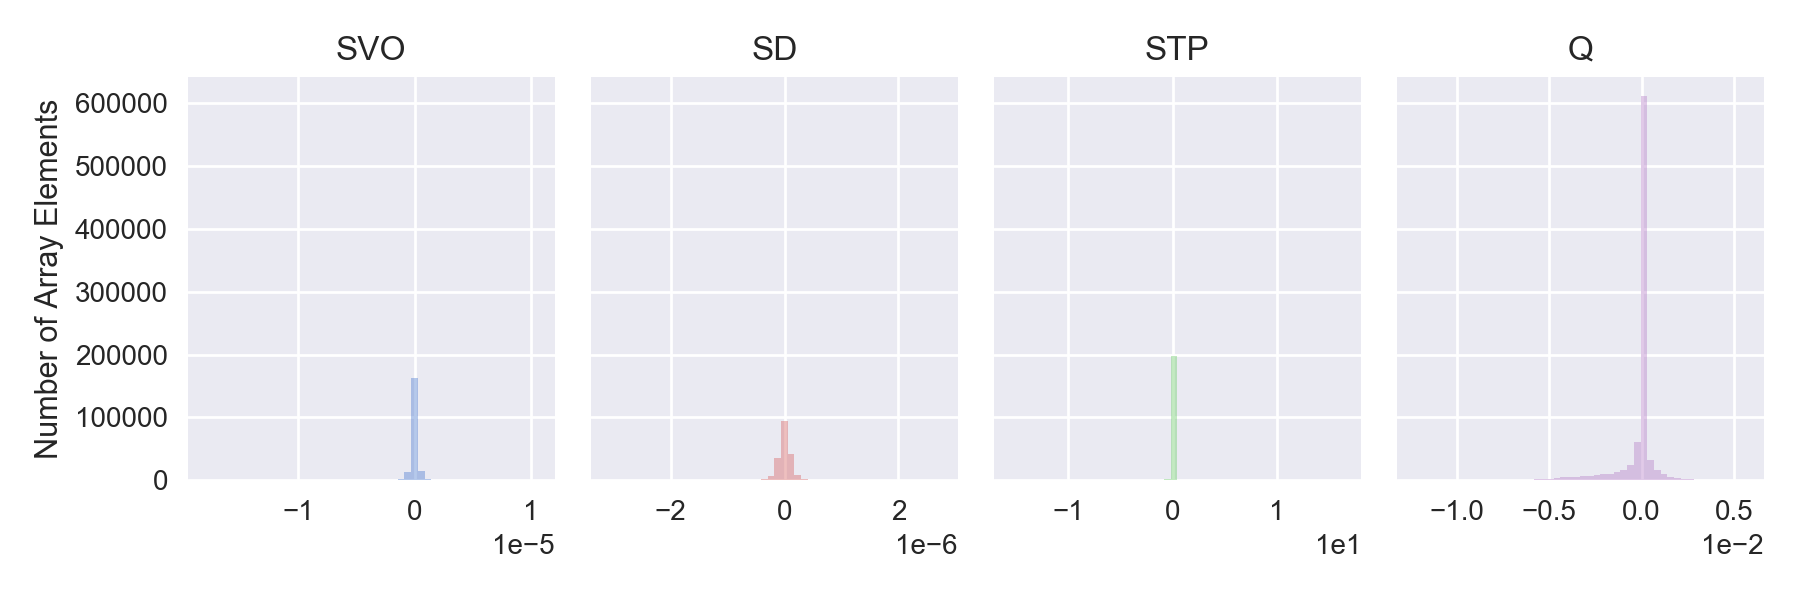

SVO 1.81066507141e-05
SD 3.11510371328e-06
STP 16.4870605394
Q 0.012324390635


In [109]:
# Plot frequency distributions of differences for initial variables  Standard vs *LGM*
f1 = netcdf.netcdf_file("data_from_mistral/T63L47_jan_spec.nc")
f2 = netcdf.netcdf_file("data_from_mistral/T63L47_jan_spec_from_Lev21ka_T63L47_without_gp2sp.nc")

plot_histograms_of_spectral_variables_between_two_files(f1, f2)

<IPython.core.display.Javascript object>


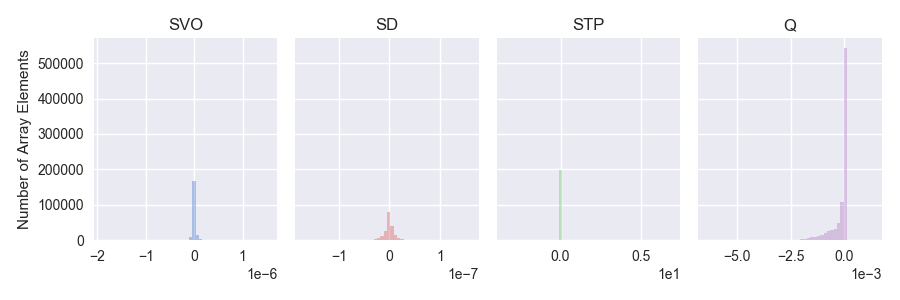

SVO 1.90249e-06
SD 1.6970071e-07
STP 6.9282
Q 0.006419914


In [114]:
f1 = netcdf.netcdf_file("data_from_mistral/T63L47_jan_spec_from_E280_T63L47_without_gp2sp.nc")
f2 = netcdf.netcdf_file("data_from_mistral/T63L47_jan_spec_from_Lev21ka_T63L47_without_gp2sp.nc")

plot_histograms_of_spectral_variables_between_two_files(f1, f2)

-------------------

## ncdump output of Standard `T63L47_jan_spec.nc`

In [7]:
%%bash
ncdump -h data_from_mistral/T63L47_jan_spec.nc

netcdf T63L47_jan_spec {
dimensions:
	lat = 96 ;
	lon = 192 ;
	nlev = 47 ;
	nlevp1 = 48 ;
	nsp = 2080 ;
	nvclev = 48 ;
	n2 = 2 ;
variables:
	double lat(lat) ;
		lat:long_name = "Gaussian latitude" ;
		lat:units = "degrees_N" ;
	double lon(lon) ;
		lon:long_name = "longitude" ;
		lon:units = "degrees_E" ;
	double vct_a(nvclev) ;
		vct_a:long_name = "vertical-coordinate parameter set A" ;
		vct_a:units = "" ;
	double vct_b(nvclev) ;
		vct_b:long_name = "vertical-coordinate parameter set B" ;
		vct_b:units = "" ;
	double SVO(nsp, n2, nlev) ;
		SVO:long_name = "vorticity" ;
		SVO:units = "1/s" ;
	double SD(nsp, n2, nlev) ;
		SD:long_name = "divergence" ;
		SD:units = "1/s" ;
	double STP(nsp, n2, nlevp1) ;
		STP:long_name = "temperature" ;
		STP:units = "K" ;
	double Q(lat, nlev, lon) ;
		Q:long_name = "specific humidity" ;
		Q:units = "kg/kg" ;

// global attributes:
		:model = "ECHAM" ;
		:institution = "Max Planck Institut f�r Meteorologie" ;
		:source_type = "IEEE+ERA" ;
		:user = "Ingo

## Changes due to `import_e5ml`
Test `orog_007` works. This means that something is changed in the `unit.23` file for `orog_006`. The **ONLY** operation that is performed is that the variable `lsp` is added to `t`, in order to have the correct dimensionality -- `STP(nsp, n2, nlevp1)`. This is accomplished with the `import_e5ml` command, which is unfortunately not documented. How does the output change:

In [26]:
%%bash
# Check how the import_e5ml operator changes the metadata

CDO=/usr/local/bin/cdo
$CDO -v import_e5ml \
data_from_mistral/T63L47_jan_spec.nc \
data_from_mistral/T63L47_jan_spec_seperated.nc

ncdump -h data_from_mistral/T63L47_jan_spec.nc > standard_metadata
ncdump -h data_from_mistral/T63L47_jan_spec_seperated.nc > seperated_metadata

# Remove the ü (it causes icdiff to break)
grep -vwe "Max" standard_metadata > blah
mv blah standard_metadata

/usr/local/bin/icdiff standard_metadata seperated_metadata
#diff -y standard_metadata seperated_metadata | /usr/local/bin/colordiff

standard_metadata                       seperated_metadata                     
netcdf T63L47_jan_spec {                netcdf T63L47_jan_spec_seperated {     
dimensions:                             dimensions:                            
                                                lon = 192 ;                    
        lat = 96 ;                              lat = 96 ;                     
        lon = 192 ;                             nc2 = 2 ;                      
        nlev = 47 ;                                                            
        nlevp1 = 48 ;                                                          
        nsp = 2080 ;                            nsp = 2080 ;                   
        nvclev = 48 ;                           lev = 47 ;                     
        n2 = 2 ;                                nhyi = 48 ;                    
                                                nhym = 47 ;                    
variables:                              

cdo import_e5ml:  ( 0.23s )


The diff output reveals that the `STP` variable is split up into `STP(lev, nsp, nc2)` and `LSP(nsp, nc2)`. Furthermore, the hybrid layer information (pressure at layer midpoints, andthe hybrid coefficients at the model layer interfaces and midpoints) is added to the output file. 

## Variables to generate `unit.23` from a `echam6` restart

The file `restart_E280_echam_27001231.nc` contains the following variables that might be used to regenerate a `unit.23` file:

| Variables in `unit.23` | Variable in `restart` |
|------------------------|-----------------------|
| `double SVO(nsp, n2, nlev) `| `double fsvo(nhgl, nmp1, complex, lev)` |
| `double SD(nsp, n2, nlev)` | `double fsd(nhgl, nmp1, complex, lev)` |
| `double STP(nsp, n2, nlevp1)` | `double fstp(nhgl, nmp1, complex, ilev)` |
| `double Q(lat, nlev, lon)` |`double q(lat, lev, lon)` |

Dimensions in `unit.23`:
- `nsp = 2080`
- `n2 = 2 `
- `nlev = 47`
- `nlevp1 = 48`
- `lat = 96`
- `lon = 192`

Dimensions in `restart`:
- `nhgl = 48`
- `nmp1 = 64`
- `complex = 2`
- `lev = 47`
- `ilev = 48`

I find it unlikely the generating a `unit.23` from `echam6` restart will be *easily* possible, as the dimensionality is not identical and not intuitively named.

## Next Steps

After discussion with G. Knorr and C. Stepanek, we have decided that this problem may be beyond our capabilities to solve without additional information from the model developers at MPI-Met. C. Stepanek and P. Gierz will write an email to S. Rast to communicate progress as well as current hinderances.

## Concluding Summary

While the procedure outlined by  S. Rast appears to function for PI climate states, performing a cold start from neither an already equilibrated `echam5` not an equilibrated `echam6` run is possible, and results in the look up table overflow error shown above.